CVaR is an improvement over VaR and is considered superior by practitioners. It takes into consideration the actual shape of the distribution and quantifies the tail risk. CVaR is also known as the expected shortfall since it measures the expectation of all the different possible losses greater than VaR.

In [18]:
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt

In [19]:
oex = ['MMM','T','ABBV','ABT','ACN','ALL','GOOGL','GOOG','MO','AMZN','AXP','AIG','AMGN','AAPL','BAC',
       'BRK-B','BIIB','BLK','BA','BMY','CVS','COF','CAT','CVX','CSCO','C','KO','CL','CMCSA',
       'COP','DHR','DUK','DD','EMC','EMR','EXC','XOM','META','FDX','F','GD','GE','GM','GILD',
       'GS','HAL','HD','HON','INTC','IBM','JPM','JNJ','KMI','LLY','LMT','LOW','MA','MCD','MDT','MRK',
       'MET','MSFT','MS','NKE','NEE','OXY','ORCL','PYPL','PEP','PFE','PM','PG','QCOM',
       'SLB','SPG','SO','SBUX','TGT','TXN','BK','USB','UNP','UPS','UNH','VZ','V','WMT',
       'WBA','DIS','WFC']

num_stocks = len(oex)

data = yf.download(oex, start='2010-01-01', end='2022-12-31')

returns = data['Adj Close'].pct_change()
returns = returns - returns.mean(skipna=True) # de-mean the returns

[*********************100%***********************]  90 of 90 completed


<BarContainer object of 90 artists>

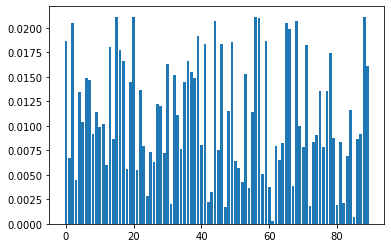

In [20]:
def scale(x):
    return x / np.sum(np.abs(x))

#random weight
weights = scale(np.random.random(num_stocks))
plt.bar(np.arange(num_stocks),weights)

Step 2: Compute VaR and CVaR

In [21]:
value_invested = 10000

def value_at_risk(
    value_invested, 
    returns, weights, 
    alpha=0.95, 
    lookback_days=500
):
    returns = returns.fillna(0.0)
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    
    return np.percentile(portfolio_returns, 100 * (1-alpha)) * value_invested

In [22]:
"""First, replace any NaNs with 0.0s in the DataFrame of returns. 
Then take the last few days of returns and multiply them by the portfolio weights to create portfolio returns. 
Finally, compute VaR by taking the 5th percentile of returns and multiplying it by the value invested. 
This gets the amount you can expect to lose in one day with 95% confidence.

This is the main difference between VaR and CVaR. 
VaR represents a worst-case loss associated with a probability and a time horizon. 
CVaR is the expected loss if that worst-case threshold is crossed. 
In other words, CVaR quantifies the expected losses that occur beyond the VaR cutoff. 
VaR only measures the cutoff.
"""

def cvar(
    value_invested, 
    returns, 
    weights, 
    alpha=0.95, 
    lookback_days=500
):
    var = value_at_risk(value_invested, returns, weights, alpha, lookback_days=lookback_days)
    
    returns = returns.fillna(0.0)
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    var_pct_loss = var / value_invested
    
    return np.nanmean(portfolio_returns[portfolio_returns < var_pct_loss]) * value_invested

#Compute VaR to get the cutoff point on the distribution that equals the 5th percentile. 
#Then compute the portfolio returns and convert VaR back to a percentage instead of a dollar amount. 
#To compute CVaR, take the average of all returns less than VaR and multiply by the invested value.
#Taking the average of all returns less than VaR is the same as taking the area of the distribution left of that cutoff point.

Step 3: Vizualize the difference between the two

In [23]:
cvar(value_invested, returns, weights)

-260.56763132406695

In [24]:
value_at_risk(value_invested, returns, weights)

-187.5999493794858

CVaR is a bigger negative number than VaR. 
The difference between the two is the extra information CVaR captures by taking the average of all returns less than VaR. 
If you are dependent on VaR for risk management, you miss that information.



Text(0, 0.5, 'Observation Frequency')

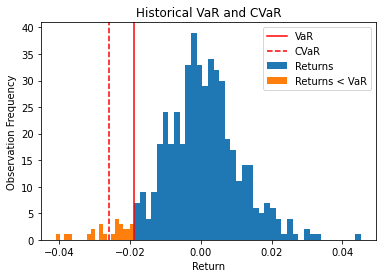

In [25]:
lookback_days = 500

portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights)
portfolio_VaR_return = portfolio_VaR / value_invested

portfolio_CVaR = cvar(value_invested, returns, weights)
portfolio_CVaR_return = portfolio_CVaR / value_invested

plt.hist(portfolio_returns[portfolio_returns > portfolio_VaR_return], bins=40)
plt.hist(portfolio_returns[portfolio_returns < portfolio_VaR_return], bins=20)
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid')
plt.axvline(portfolio_CVaR_return, color='red', linestyle='dashed')
plt.legend(['VaR', 'CVaR', 'Returns', 'Returns < VaR'])
plt.title('Historical VaR and CVaR')
plt.xlabel('Return')
plt.ylabel('Observation Frequency')

# Fama-French factor model

In [47]:
# pandas_datareader to download the factor data and yfinance to download stock price data. 
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf

# Use statsmodels for modeling.
import statsmodels.api as sm
from statsmodels import regression
from statsmodels.regression.rolling import RollingOLS

In [48]:
factors = pdr.get_data_famafrench(
    'F-F_Research_Data_Factors',
    start='2000-01-01'
)[0][1:]

SMB = factors.SMB
HML = factors.HML

SMB is “small minus big” representing the size factor. 
HML is “high minus low” representing the style factor. 
This also downloads a third factor, Rm-Rf, which is the market excess return. 
I only use SMB and HML for this analysis.

Now get the stock price data for your portfolio. You can pick any stocks you want. (Make sure to include a benchmark like SPY.)

In [49]:
data = yf.download(
    ['SPY', 'MSFT', 'AAPL', 'INTC'], 
    start="2000-01-01", 
    interval="1mo"
)['Adj Close']

monthly_returns = data.pct_change().to_period("M")

[*********************100%***********************]  4 of 4 completed


The factor data is monthly so to align with the stock data, you need to get monthly closing prices and resample to monthly labels. pandas makes it easy.

Step 2: Compute the sensitivities to the factors
Next, compute the active return of the portfolio. The active return is the portfolio return minus the benchmark return.

In [51]:
bench = monthly_returns.pop("SPY")
R = monthly_returns.mean(axis=1)
active = R - bench

In [68]:
# Use regression to compute the sensitivities to the factors.

df = pd.DataFrame({
    'R': active,
    'F1': SMB,
    'F2': HML,
}).dropna()

b1, b2 = regression.linear_model.OLS(
    df.R, 
    df[['F1', 'F2']]
).fit().params

print(f'Sensitivities of active returns to factors:\nSMB: {b1}\nHML: {b2}')

Sensitivities of active returns to factors:
SMB: 0.0012978605085464862
HML: -0.0027952640886995525


Put the active returns and factors into a DataFrame to make it easy to align the dates. Then run a regression with the active returns as the dependent variable on the factors. Fitting the model gives you the two coefficients that determine the sensitivities of the portfolio’s active returns to the factors.

The sensitivities are estimates so it’s important to see how they evolve through time with their confidence intervals.

In [ ]:
# endog = bench - factors[exog_vars]
exog_vars = ["SMB", "HML"]
exog = sm.add_constant(factors[exog_vars])
rols = RollingOLS(df.R, exog, window=12)
rres = rols.fit()
fig = rres.plot_recursive_coefficient(variables=exog_vars)

Step 3: Figure out the risk contribution of the factors
Marginal Contribution To Active Risk (MCTAR) measures the incremental active risk each additional factor introduces to your portfolio.

In [ ]:
# The sensitivities tell you how much the active portfolio returns change in response to changes in the factors. 
# In other words, how the factors drive the active portfolio returns.

In [72]:
F1 = df.F1
F2 = df.F2

cov = np.cov(F1, F2)
ar_squared = (active.std())**2
mcar1 = (b1 * (b2 * cov[0,1] + b1 * cov[0,0])) / ar_squared
mcar2 = (b2 * (b1 * cov[0,1] + b2 * cov[1,1])) / ar_squared
print (f'SMB risk contribution: {mcar1}')
print (f'HML risk contribution: {mcar2}')
print (f'Unexplained risk contribution: {1 - (mcar1 + mcar2)}')

SMB risk contribution: 0.014184848078807629
HML risk contribution: 0.06171252324262849
Unexplained risk contribution: 0.9241026286785639


To figure out the factors’ MCTAR, multiply the factor sensitivity by the covariance between the factors. Then divide by the standard deviation of the active returns, squared.

This tells you how much risk you take on by being exposed to each factor given the other factors you’re already exposed to. The unexplained risk contribution is the exposure you have to other factors outside of the two you analyzed.

You can use this analysis to increase or decrease your exposure to these factors. You would do this by under- or overweighting the stocks that represent these factors (e.g. large cap or value).

# 3 Fama-French factors and the 10 industry portfolios.

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

seaborn.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [59]:
factors = pdr.get_data_famafrench("F-F_Research_Data_Factors", start="1-1-1926")[0]
factors.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07,2.96,-2.56,-2.43,0.22
1926-08,2.64,-1.17,3.82,0.25
1926-09,0.36,-1.40,0.13,0.23
1926-10,-3.24,-0.09,0.70,0.32
1926-11,2.53,-0.10,-0.51,0.31


The data are monthly returns for the factors or industry portfolios.

In [60]:
factors = pdr.get_data_famafrench("F-F_Research_Data_Factors", start="1-1-1926")[0]
factors.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07,2.96,-2.56,-2.43,0.22
1926-08,2.64,-1.17,3.82,0.25
1926-09,0.36,-1.40,0.13,0.23
1926-10,-3.24,-0.09,0.70,0.32
1926-11,2.53,-0.10,-0.51,0.31


In [61]:
industries = pdr.get_data_famafrench("10_Industry_Portfolios", start="1-1-1926")[0]
industries.head()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1926-07,1.45,15.55,4.69,-1.18,2.90,0.83,0.11,1.77,7.04,2.13
1926-08,3.97,3.68,2.81,3.47,2.66,2.17,-0.71,4.25,-1.69,4.35
1926-09,1.14,4.80,1.15,-3.39,-0.38,2.41,0.21,0.69,2.04,0.29
1926-10,-1.24,-8.23,-3.63,-0.78,-4.58,-0.11,-2.29,-0.57,-2.63,-2.84
1926-11,5.20,-0.19,4.10,0.01,4.71,1.63,6.43,5.42,3.71,2.11


The first model estimated is a rolling version of the CAPM that regresses the excess return of Technology sector firms on the excess return of the market.

The window is 60 months, and so results are available after the first 60 (window) months. The first 59 (window - 1) estimates are all nan filled.

In [62]:
endog = industries.HiTec - factors.RF.values
exog = sm.add_constant(factors["Mkt-RF"])
rols = RollingOLS(endog, exog, window=60)
rres = rols.fit()
params = rres.params.copy()
params.index = np.arange(1, params.shape[0] + 1)
params.head()

,const,Mkt-RF
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN


In [63]:
params.iloc[57:62]

,const,Mkt-RF
58,NaN,NaN
59,NaN,NaN
60,0.876155,1.399240
61,0.879936,1.406578
62,0.953169,1.408826


In [64]:
params.tail()

,const,Mkt-RF
1154,0.400821,1.083680
1155,0.402404,1.097028
1156,0.281329,1.076928
1157,0.319787,1.079756
1158,0.315997,1.086256


We next plot the market loading along with a 95% point-wise confidence interval. The alpha=False omits the constant column, if present.

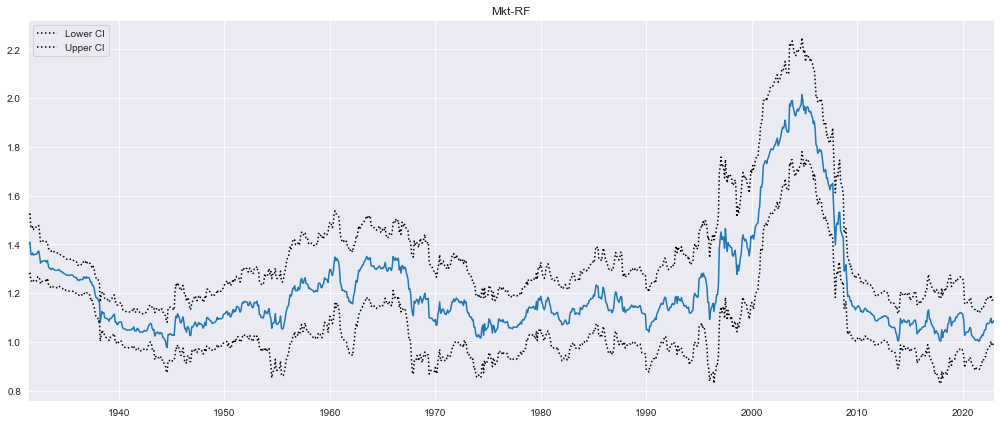

In [65]:
fig = rres.plot_recursive_coefficient(variables=["Mkt-RF"], figsize=(14, 6))

Next, the model is expanded to include all three factors, the excess market, the size factor and the value factor.

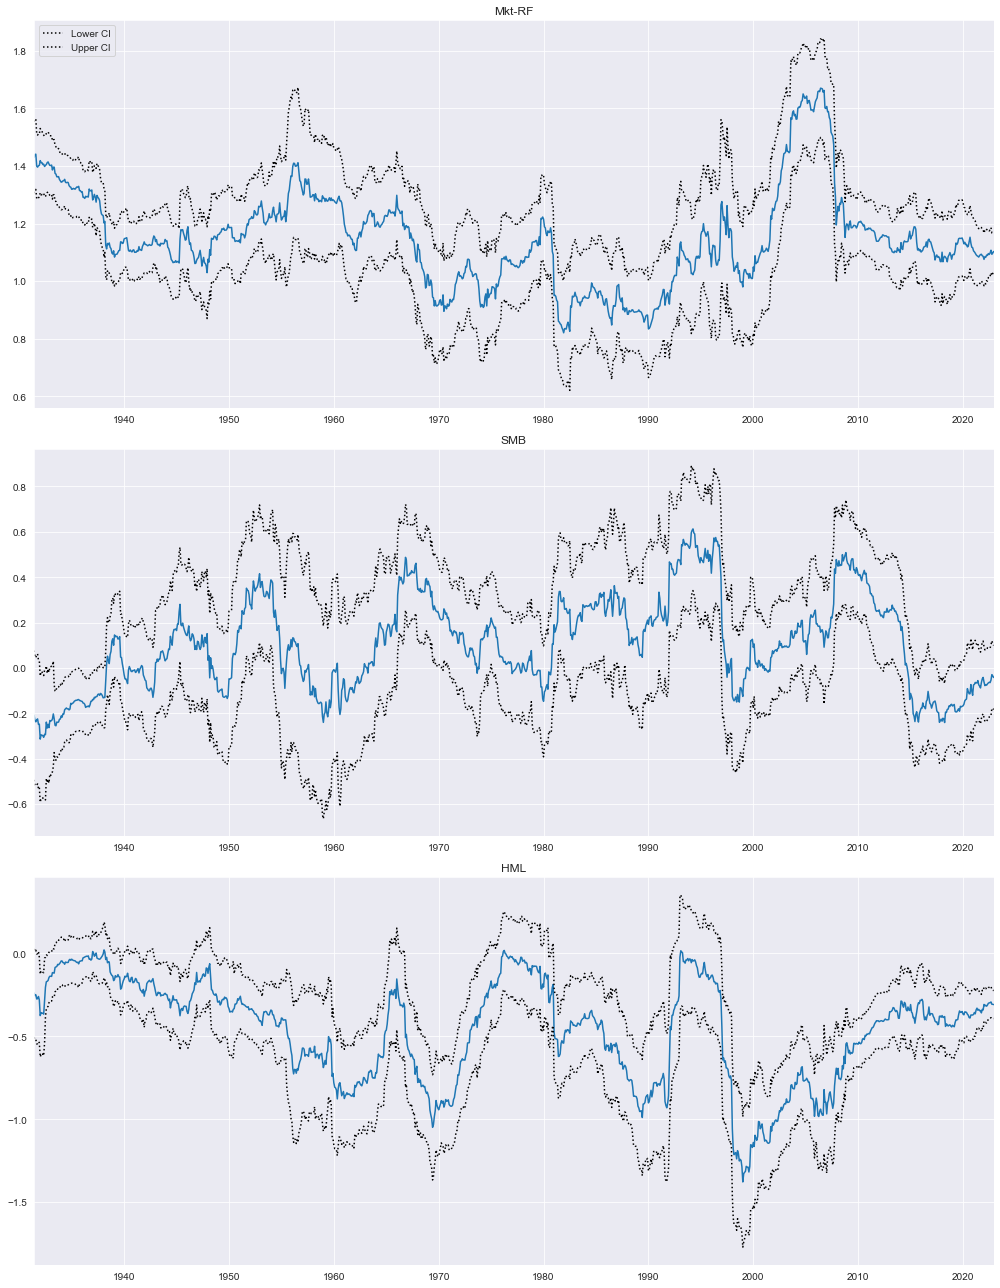

In [66]:
exog_vars = ["Mkt-RF", "SMB", "HML"]
exog = sm.add_constant(factors[exog_vars])
rols = RollingOLS(endog, exog, window=60)
rres = rols.fit()
fig = rres.plot_recursive_coefficient(variables=exog_vars, figsize=(14, 18))